# Deep Convolutional GAN

This code is based on [_Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (2015)_](https://arxiv.org/abs/1406.2661) paper by Alec Radford, Luke Metz, et all.

## Environment Setup

In [1]:
import torch

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using %s" % (device))

using cuda


## Prepare Dataset

Dataset used: [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

![CelebA Example](https://pytorch.org/tutorials/_images/sphx_glr_dcgan_faces_tutorial_001.png)

In [2]:
from torchvision import datasets, transforms

celeba_size = 64
celeba_channel = 3
celeba_shape = [celeba_channel, celeba_size, celeba_size]

# setup CelebA dataset
transform = transforms.Compose([
    transforms.Resize(celeba_size),
    transforms.CenterCrop(celeba_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# celeba_dataset = datasets.CelebA(
#     root="./datasets", transform=transform, download=True)

celeba_dataset = datasets.ImageFolder(
    root="./datasets/celeba", transform=transform)

# data loader (input pipeline)
data_loader = torch.utils.data.DataLoader(
    dataset=celeba_dataset, batch_size=100, shuffle=True)

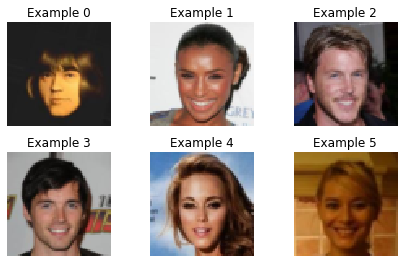

In [3]:
import matplotlib.pyplot as plt
import numpy as np

examples = enumerate(data_loader)
_, (example_data, _) = next(examples)

# plot example data
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()

    img = (example_data[i].numpy() + 1) / 2
    plt.imshow(np.transpose(img, (1, 2, 0)))

    plt.title("Example %d" % i)
    plt.axis('off')

plt.show()

## Build Models

![DCGAN Generator Model](https://pytorch.org/tutorials/_images/dcgan_generator.png)

In [4]:
import torch.nn as nn


# generator model
class Generator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Generator, self).__init__()

        def blocks(in_dim, out_dim, kernel_size=4, stride=2, padding=1):
            conv_layer = nn.ConvTranspose2d(in_dim, out_dim, kernel_size,
                                            stride, padding, bias=False)
            return [conv_layer,
                    nn.BatchNorm2d(out_dim),
                    nn.ReLU(True)]

        self.model = nn.Sequential(
            *blocks(in_dim, 512, stride=1, padding=0),
            *blocks(512, 256),
            *blocks(256, 128),
            *blocks(128, 64),
            nn.ConvTranspose2d(64, out_dim, 4, 2, 1, bias=False),
            nn.Tanh())

    def forward(self, noise):
        output = self.model(noise.view(*noise.shape, 1, 1))
        image = output.view(output.size(0), *celeba_shape)
        return image

In [5]:
# discriminator model
class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super(Discriminator, self).__init__()

        def blocks(in_dim, out_dim, normalize=False):
            layers = [nn.Conv2d(in_dim, out_dim, 4, 2, 1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *blocks(in_dim, 64),
            *blocks(64, 128, normalize=True),
            *blocks(128, 256, normalize=True),
            *blocks(256, 512, normalize=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, image):
        validity = self.model(image)
        return validity.view(validity.size(0), -1)

In [6]:
noise_dim = 100
celeba_dim = celeba_channel

# build model
generator = Generator(in_dim=noise_dim, out_dim=celeba_dim).to(device)
discriminator = Discriminator(in_dim=celeba_dim).to(device)

print(generator, discriminator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Train Process

In [7]:
# loss criterion
criterion = nn.BCELoss().to(device)

# optimizers
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

if torch.cuda.is_available():
    FloatTensor = torch.cuda.FloatTensor
else:
    FloatTensor = torch.FloatTensor

In [8]:
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import time
import os

start = time.time()

g_losses = []
d_losses = []

epochs = 10
batches = 1000

# train process
for epoch in range(epochs):

    g_loss_sum = 0
    d_loss_sum = 0

    for i, (imgs, _) in enumerate(data_loader):

        if i >= batches:
            break

        batch_size = imgs.size(0)

        # adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0),
                         requires_grad=False)

        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0),
                        requires_grad=False)

        # configure input
        real_imgs = Variable(imgs.type(FloatTensor))

        # -----------------
        #  Train Generator
        # -----------------

        g_optimizer.zero_grad()

        # sample noise as generator input
        noise = Variable(FloatTensor(
            np.random.normal(0, 1, (batch_size, noise_dim))))

        # generate a batch of images
        gen_imgs = generator(noise)

        # adversarial loss
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss_sum += g_loss.item()

        g_loss.backward()
        g_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        d_optimizer.zero_grad()

        # adversarial loss
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss_sum += d_loss.item()

        d_loss.backward()
        d_optimizer.step()

        elapsed = time.time() - start
        print("\r[Elapsed %02d:%02d]" % (elapsed // 60, elapsed % 60), end='')

        print(" [Epoch %d/%d] [Batch %d/%d]"
              % (epoch+1, epochs, i+1, batches), end='')

        print(" [G loss: %f] [D loss: %f]"
              % (g_loss.item(), d_loss.item()), end='')

    g_losses.append(g_loss_sum / batches)
    d_losses.append(d_loss_sum / batches)

    # generate a batch of sample images from noise
    noise = Variable(FloatTensor(
        np.random.normal(0, 1, (25, noise_dim))))
    gen_imgs = generator(noise)

    # save sample images
    os.makedirs("./samples/dcgan", exist_ok=True)
    save_image(gen_imgs, "./samples/dcgan/sample_%02d.png" % (epoch + 1),
               nrow=5, normalize=True)

# save result models
os.makedirs("./models/dcgan", exist_ok=True)
torch.save(generator, "./models/dcgan/generator.pt")
torch.save(discriminator, "./models/dcgan/discriminator.pt")

[Elapsed 84:35] [Epoch 10/10] [Batch 1000/1000] [G loss: 2.097600] [D loss: 0.145871]

## Train Result

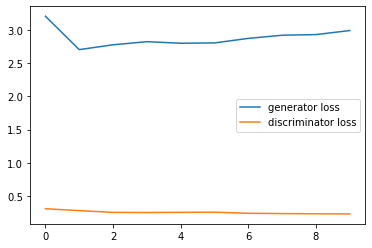

In [9]:
# plot losses
plt.plot(g_losses, label="generator loss")
plt.plot(d_losses, label="discriminator loss")
plt.legend()
plt.show()

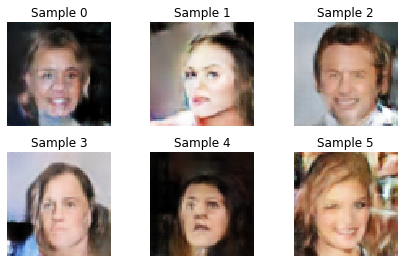

In [10]:
# generate a batch of sample images from noise
noise = Variable(FloatTensor(
    np.random.normal(0, 1, (6, noise_dim))))
gen_imgs = generator(noise)

# plot sample images
imgs = gen_imgs.cpu().detach().numpy()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()

    img = (imgs[i] + 1) / 2
    plt.imshow(np.transpose(img, (1, 2, 0)))

    plt.title("Sample %d" % i)
    plt.axis('off')

plt.show()